# Sprint9 ニューラルネットワーク

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from numpy import linalg as LA
import copy
sns.set()
%matplotlib inline
import time
import math
import copy

from mpl_toolkits.mplot3d import Axes3D
from keras.utils import np_utils

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [29]:
#Some functions to make life easier
from sklearn import metrics
import tensorflow as tf

def submit(predictions):
    submit = pd.read_csv('../input/sample_submission.csv')
    submit["target"] = predictions
    submit.to_csv("submission.csv", index=False)

def fallback_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except:
        return 0.5

def auc(y_true, y_pred):
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [30]:
# MNIST data set
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### データセットの確認 平滑化
>(1, 28, 28)の各画像を、(1, 784)に変換します。これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱います。全てのピクセルが一列になっていることを、 平滑化（flatten） してあるという風に表現します。

In [31]:
# print(X_train.shape) # (60000, 28, 28)
# print(X_test.shape) # (10000, 28, 28)
# print(X_train[0].dtype) # uint8
# print(X_train[0])

X_train = X_train.reshape(-1, 784) #平滑化
X_test = X_test.reshape(-1, 784)

《補足》

ここまで機械学習を学んでくる中で、特徴量の数を「次元」と呼んできました。その視点ではMNISTは784次元のデータです。一方で、NumPyのshapeが(784,)の状態を1次元配列とも呼びます。画像としての縦横の情報を持つ（28, 28)の状態であれば、2次元配列です。この視点では2次元のデータです。さらに、もしもカラー画像であれば(28, 28, 3)ということになり、3次元配列です。先ほどの視点では3次元のデータになります。しかし、白黒でもカラーでも平面画像であり、立体データではないという視点で、2次元のデータです。画像データを扱う際にはこのように「次元」という言葉が複数の意味合いで使われることに注意してください。

### 画像データの可視化


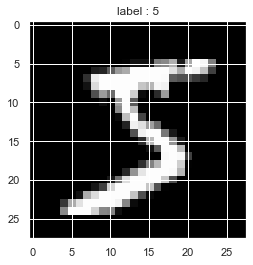

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

《発展的話題》

画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、plt.imshowはより自由な配列を画像として表示することが可能です。例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどと全く同じ風に表示されます。

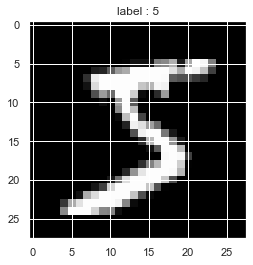

In [6]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
# print(image) # 値を確認

これは、自動的に値を0〜255の整数に変換して処理するように作られているからです。uint8型であっても最小値が0、最大値が255でない場合には色合いがおかしくなります。それを防ぐためには次のように引数を入れてください。

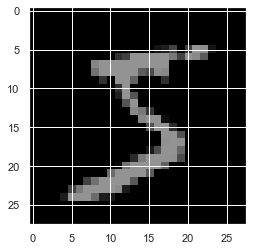

In [7]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

## 前処理
>画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。

>また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。



In [32]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [33]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


さらに、訓練用データ6万枚の内2割を検証用データとして分割してください。訓練用データが48000枚、検証用データが12000枚となります。



In [34]:
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


ミニバッチ処理
>ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。

In [11]:
'''
今回はバッチサイズを20とします。
今回使う訓練用データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。
ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。

訓練用データを一度全て見ると1回の エポック（epoch） が終わったことになります。
このエポックを複数回繰り返し、学習が完了します。

for文で呼び出すと、ミニバッチを取得できます。
'''

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [12]:
# このクラスをインスタンス化し、for文を使うことでミニバッチが取り出せます。

get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

print(len(get_mini_batch)) # 2400
print(len(get_mini_batch[5])) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

2400
2


学習
>ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲションの繰り返しになります。

## ニューラルネットワークスクラッチ


In [39]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, 
                 seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

#sigmoid計算用
def sigmoid(A):
    return 1/ (1+ np.exp(- A))
    

class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ------
    self.fptype = 'sig' or 'max' で活性化関数を選択できるように
    

    Attributes
    ----------
    """

    def __init__(self, max_iter=5,
                 lr=0.00001,verbose = True):
        self.iter = max_iter
        self.lr = lr
        self.verbose = verbose
        pass
    
    #問題1
    def weighting_and_biases_firsts(self,X,sigma=0.01,
                                    n_nodes1=400, n_nodes2=200,
                                    n_output=10):
        self.W1 = sigma * np.random.randn(X.shape[1], n_nodes1)
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
        self.W3 = sigma * np.random.randn(n_nodes2, n_output)

        self.B1 = sigma * np.random.randn(n_nodes1)
        self.B2 = sigma * np.random.randn(n_nodes2)
        self.B3 = sigma * np.random.randn(n_output)
    #問題1
    
    #問題２　前半　更新式
    def forward_propagation(self,X):
        #self.z の更新式
        if self.fptype == 'sig': #シグモイド関数
            self.z1 = sigmoid(X @ self.W1 + self.B1) #(batch_size, n_nodes1)
            self.z2 = sigmoid(self.z1 @ self.W2 + self.B2) #(batch_size, n_nodes2)
            self.z3 = sigmoid(self.z2 @ self.W3 + self.B3) #(batch_size, n_output) 

        elif self.fptype == 'hipo': #ハイパボリックタンジェント関数
            self.z1 = np.tanh(X @ self.W1 + self.B1) #(batch_size, n_nodes1)
            self.z2 = np.tanh(self.z1 @ self.W2 + self.B2) #(batch_size, n_nodes2)
            self.z3 = np.tanh(self.z2 @ self.W3 + self.B3) #(batch_size, n_output)
    #問題２　前半 更新式
    
    #問題２　後半 softmax
    def soft_max(self):
        A = self.z2 @ self.W3 + self.B3
        # 分母 n_output方向にsum. reshapeして　分子を行ごとに割り算
        soft = np.sum(np.exp(A) / np.sum(np.exp(A)),axis=1)
#         print(soft)
        return np.exp(A) / np.sum(np.exp(A))
    #ここの更新後self.z3は各ラベル（0〜9）に対する確率の配列。->(batch_size,)のベクトル
    #問題２　後半 softmax
    
    #問題3
    def loss_func(self,y,y_pred_proba):
        sigma_c = np.sum(y * np.log(y_pred_proba), axis = 1) #のbatch_size平均
        # -1 * ((y_test @ np.log(y_pred_proba).T)のbatch_size平均)
        return -np.mean(sigma_c)
    #問題3
    
    #問題4 #weight, bias の更新式 # 確率的勾配降下法
    #3層目から逆算していく。3層目から更新していく。
    def back_propagation(self,X,y): #Xの所にmini_X_train を入れること
        
        slope_A3 = self.z3 - y   #勾配 (batch_size, n_output)
        self.W3 = self.W3 - self.lr * (self.z2.T @ slope_A3) #(n_nodes2, n_output)
        self.B3 = self.B3 - self.lr * np.sum(slope_A3,axis=0) #(n_output,)
        
        slope_Z2 = slope_A3 @ self.W3.T #(batch_size, n_nodes2)
        
        if self.fptype == 'sig': #シグモイド関数
            slope_A2 =slope_Z2 * ((1- sigmoid(self.z2 @ self.W2 + self.B2))*sigmoid(self.z2 @ self.W2 + self.B2))
            self.W2 = self.W2 - self.lr * self.z1.T @ slope_A2 #(n_nodes1, n_nodes2)
            self.B2 = self.B2 - self.lr * np.sum(slope_A2,axis=0) #(n_nodes2,)
                
            slope_Z1 = slope_A2 @ self.W2.T #(batch_size, n_nodes1)
            
            slope_A1 =slope_Z1 * ((1- sigmoid(self.z1 @ self.W1 + self.B1))*sigmoid(self.z1 @ self.W1 + self.B1))
            self.W1 = self.W1 - self.lr * X.T @ slope_A1 #(n_nodes1, n_nodes2)
            self.B1 = self.B1 - self.lr * np.sum(slope_A1,axis=0) #(n_nodes2,)

        elif self.fptype == 'max': #ハイパボリックタンジェント関数
            slope_A2= slope_Z2 * ((np.tanh(self.z2 @ self.W2 + self.B2))**2)
            self.W2 = self.W2 - self.lr * self.z1.T @ slope_A2 #(n_nodes1, n_nodes2)
            self.B2 = self.B2 - self.lr * np.sum(slope_A2,axis=0) #(n_nodes2,)
        
            slope_Z1 = slope_A2 @ self.W2.T #(batch_size, n_nodes1)
            
            slope_A1= slope_Z1 * ((np.tanh(self.z1 @ self.W1 + self.B1))**2)
            self.W1 = self.W1 - self.lr * X.T @ slope_A1 #(n_nodes1, n_nodes2)
            self.B1 = self.B1 - self.lr * np.sum(slope_A1,axis=0) #(n_nodes2,)
    #問題4
    
    def fit(self, X, y, fptype='hipo',
            sigma = 0.01,n_nodes1 = 400,n_nodes2 = 200,
            n_output = 10, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        '''
        WとBが層を跨がない、バッチ間、エポック間はまたぐ
        '''
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.fptype = fptype #活性化関数指定
        self.loss = None
        self.weighting_and_biases_firsts(X) #初期値セット


        for n in range(self.iter): #何回回そう？ MNISTなら50回ほどで試す
            get_mini_batch = GetMiniBatch(X_train,
                                          y_train_one_hot,
                                          batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:
            # このfor文内でミニバッチが使える
                self.forward_propagation(mini_X_train)    
                self.back_propagation(mini_X_train,mini_y_train)
                self.soft_max()
        
            if self.fptype == 'sig': #シグモイド関数
                z1 = sigmoid(X @ self.W1 + self.B1) #(batch_size, n_nodes1)
                z2 = sigmoid(z1 @ self.W2 + self.B2) #(batch_size, n_nodes2)

            elif self.fptype == 'hipo': #ハイパボリックタンジェント関数
                z1 = np.tanh(X @ self.W1 + self.B1) #(batch_size, n_nodes1)
                z2 = np.tanh(z1 @ self.W2 + self.B2) #(batch_size, n_nodes2)

            a3_exp = copy.deepcopy(np.exp(z2 @ self.W3 + self.B3))
            # 分母 n_output方向にsum. reshapeして　分子を行ごとに割り算
            z3 = a3_exp / np.sum(a3_exp)
            y_pred_proba = z3
            loss = self.loss_func(y,y_pred_proba)
            self.loss = np.append(self.loss,loss)
        
        self.loss = np.delete(self.loss, 0)
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
#             print(self.loss)
            print("self.loss.shape",self.loss.shape)
        

    def predict(self, X,fptype='hipo'):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        self.fptype = fptype
        if self.fptype == 'sig': #シグモイド関数
            z1 = sigmoid(X @ self.W1 + self.B1) #(batch_size, n_nodes1)
            z2 = sigmoid(z1 @ self.W2 + self.B2) #(batch_size, n_nodes2)

        elif self.fptype == 'hipo': #ハイパボリックタンジェント関数
            z1 = np.tanh(X @ self.W1 + self.B1) #(batch_size, n_nodes1)
            z2 = np.tanh(z1 @ self.W2 + self.B2) #(batch_size, n_nodes2)

        A3_exp = copy.deepcopy(np.exp(z2 @ self.W3 + self.B3))
        # 分母 n_output方向にsum. reshapeして　分子を行ごとに割り算
        y_pred_proba = A3_exp / np.sum(A3_exp)
        y_pred_one_hot = np.argmax(y_pred_proba,axis=1)
        return y_pred_one_hot

In [40]:
y_train_one_hot.shape #(48000, 10)

(48000, 10)

In [46]:
NN = ScratchSimpleNeuralNetrowkClassifier(max_iter=50,
                                          lr=0.01,
                                          verbose = True)

In [47]:
t1 = time.time()
NN.fit(X_train, y_train_one_hot,fptype='hipo')

t2 = time.time()
print("processing time:",t2-t1)
# sample 48000 , class 10 

self.loss.shape (50,)
processing time: 77.5775818824768


In [48]:
# y_test_one_hot.shape #(10000, 10)
# X_test.shape #(10000, 784)

In [49]:
#問題５,6
from sklearn.metrics import accuracy_score

y_pred = NN.predict(X_test)
print("accuracy",accuracy_score(np.argmax(y_test_one_hot,axis=1),y_pred))


accuracy 0.842


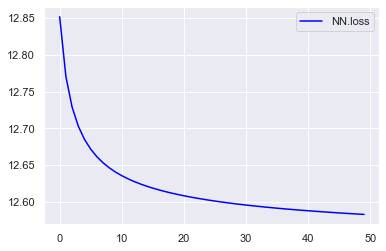

In [50]:
#問題7
plt.plot(NN.loss,label='NN.loss', color = 'blue')
# plt.plot(slr.val_loss,label='slr.val_loss', color = 'orange')
plt.grid(True)                                 # グリッド線を表示
plt.legend()

## 【問題1】重みの初期値を決めるコードの作成
>重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。



In [ ]:
'''
n_features = 784
n_nodes1 = 400 # 1層目のノード数
sigma = 0.01 # ガウス分布の標準偏差(ハイパーパラメータ)
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)
print(W1.shape)

一層目は上記。
二層目を作る。(node数,n_nodes2) # 2層目のノード数
'''

# nodes を list でもらってfor文にして汎化してもいいが、今回はその必要がない。
#問題1
def weighting_and_biases_firsts(self,X,sigma = 0.01,
                                n_nodes1 = 400,n_nodes2 = 200,
                                n_output = 10):
    self.W1 = sigma * np.random.randn(X.shape[1], n_nodes1)
    self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
    self.W3 = sigma * np.random.randn(n_nodes2, n_output)

    self.B1 = sigma * np.random.randn(n_nodes1)
    self.B2 = sigma * np.random.randn(n_nodes2)
    self.B3 = sigma * np.random.randn(n_output)

    print("W1{},W2{},W3{},B1{},B2{},B3{}"\
          .format(self.W1.shape, self.W2.shape, self.W3.shape,
                  self.B1.shape, self.B2.shape, self.B3.shape))
#問題1

## 【問題2】フォワードプロパゲーションの実装
>三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。



In [ ]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

In [ ]:
'''
#問題２　前半　更新式
def forward_propagation_1(self):
    #self.z の更新式
    if self.fptype == 'sig': #シグモイド関数
        self.z1 = 1/ (1+ np.exp(- (self.z1 @ self.W1 + self.B1))) 
        print("sig",self.z1.shape) #(batch_size, n_nodes1)

    if self.fptype == 'max': #ハイパボリックタンジェント関数
        self.z1 = np.tanh(self.z1 @ self.W1 + self.B1)
        print("max",self.z1.shape) #(batch_size, n_nodes1)

    else: 
        print('Error! : fptype none')


def forward_propagation_2(self):
    #self.z の更新式
    if self.fptype == 'sig': #シグモイド関数
        self.z2 = 1/ (1+ np.exp(- (self.z2 @ self.W2 + self.B2))) 
        print("sig",self.z2.shape) #(batch_size, n_nodes2)

    if self.fptype == 'max': #ハイパボリックタンジェント関数
        self.z2 = np.tanh(self.z2 @ self.W2 + self.B2)
        print("max",self.z2.shape) #(batch_size, n_nodes2)

    else: 
        print('Error! : fptype none')

def forward_propagation_3(self):
    #self.z の更新式
    if self.fptype == 'sig': #シグモイド関数
        self.z3 = 1/ (1+ np.exp(- (self.z3 @ self.W3 + self.B3))) 
        print("sig",self.z3.shape) #(batch_size, n_output) 

    if self.fptype == 'max': #ハイパボリックタンジェント関数
        self.z3 = np.tanh(self.z3 @ self.W3 + self.B3)
        print("max",self.z3.shape) #(batch_size, n_output)

    else: 
        print('Error! : fptype none')
#問題２　前半 更新式

#問題２　後半 softmax
def soft_max(self,X):
    a_exp = copy.deepcopy(np.exp(self.z @ self.W3 + self.B3))
    # 分母 n_output方向にsum. reshapeして　分子を行ごとに割り算
    self.z = a_exp / np.sum(a_exp).reshape(batch_size,1) 
    print("更新後self.z(batch_size,n_output)",self.z.shape)
    return self.z 
#ここの更新後self.zは各ラベル（0〜9）に対する確率の配列。->(batch_size,)のベクトル
#問題２　後半 softmax
'''

### 活性化関数（フォワードプロバゲーション）
>活性化関数を作成し、フォワードプロパゲーションの中で使用します。切り替えられるように実装することを推奨しますが、片方でも構いません。

In [ ]:
'''訂正版'''
#問題２　前半　更新式
def forward_propagation(self,X):
    #self.z の更新式
    if self.fptype == 'sig': #シグモイド関数
        self.z1 = sigmoid(X @ self.W1 + self.B1)
        print("sig",self.z1.shape) #(batch_size, n_nodes1)
        self.z2 = sigmoid(self.z1 @ self.W2 + self.B2)
        print("sig",self.z2.shape) #(batch_size, n_nodes2)
        self.z3 = sigmoid(self.z2 @ self.W3 + self.B3)
        print("sig",self.z3.shape) #(batch_size, n_output) 

    if self.fptype == 'max': #ハイパボリックタンジェント関数
        self.z1 = np.tanh(X @ self.W1 + self.B1)
        print("max",self.z1.shape) #(batch_size, n_nodes1)
        self.z2 = np.tanh(self.z1 @ self.W2 + self.B2)
        print("max",self.z2.shape) #(batch_size, n_nodes2)
        self.z3 = np.tanh(self.z2 @ self.W3 + self.B3)
        print("max",self.z3.shape) #(batch_size, n_output)

    else: 
        print('Error! : fptype none')
#問題２　前半 更新式




### ソフトマックス関数

In [ ]:
#問題２　後半 softmax
def soft_max(self):
    a_exp = copy.deepcopy(np.exp(self.z3 @ self.W3 + self.B3))
    # 分母 n_output方向にsum. reshapeして　分子を行ごとに割り算
    self.z3 = a_exp / np.sum(a_exp).reshape(batch_size,1) 
    print("更新後self.z(batch_size,n_output)",self.z3.shape)
    return self.z3
#ここの更新後self.z3は各ラベル（0〜9）に対する確率の配列。->(batch_size,)のベクトル
#問題２　後半 softmax

## 【問題3】交差エントロピー誤差の実装

In [ ]:
#問題3
def loss_func(self,y,y_pred_proba):
    sigma_c = np.sum(y * np.log(y_pred_proba), axis = 1) #のbatch_size平均
    # -1 * ((y_test @ np.log(y_pred_proba).T)のbatch_size平均)
    return -np.mean(sigma_c)
#問題3

## 【問題4】バックプロパゲーションの実装

In [ ]:
'''確率的工場行こうか法(バックプロパゲーション実装)をやること。
「バッチサイズ x イテレーション(更新回数) = trainデータサンプル数」
理解してから学習エポック数を設定すること(ハイパーパラメーター)。'''     
        
#問題4 #weight, bias の更新式 # 確率的勾配降下法
#3層目から逆算していく。3層目から更新していく。
#問題4 #weight, bias の更新式 # 確率的勾配降下法
#3層目から逆算していく。3層目から更新していく。
def back_propagation(self,X,y): #Xの所にmini_X_train を入れること

    slope_A3 = self.z3 - y   #勾配 (batch_size, n_output)
    self.W3 = self.W3 - self.lr * (self.z2.T @ slope_A3) #(n_nodes2, n_output)
    self.B3 = self.B3 - self.lr * np.sum(slope_A3,axis=0) #(n_output,)

    slope_Z2 = slope_A3 @ self.W3.T #(batch_size, n_nodes2)

    if self.fptype == 'sig': #シグモイド関数
        slope_A2 =slope_Z2 * ((1- sigmoid(self.z2 @ self.W2 + self.B2))*sigmoid(self.z2 @ self.W2 + self.B2))
        self.W2 = self.W2 - self.lr * self.z1.T @ slope_A2 #(n_nodes1, n_nodes2)
        self.B2 = self.B2 - self.lr * np.sum(slope_A2,axis=0) #(n_nodes2,)

        slope_Z1 = slope_A2 @ self.W2.T #(batch_size, n_nodes1)

        slope_A1 =slope_Z1 * ((1- sigmoid(self.z1 @ self.W1 + self.B1))*sigmoid(self.z1 @ self.W1 + self.B1))
        self.W1 = self.W1 - self.lr * X.T @ slope_A1 #(n_nodes1, n_nodes2)
        self.B1 = self.B1 - self.lr * np.sum(slope_A1,axis=0) #(n_nodes2,)

    elif self.fptype == 'max': #ハイパボリックタンジェント関数
        slope_A2= slope_Z2 * ((np.tanh(self.z2 @ self.W2 + self.B2))**2)
        self.W2 = self.W2 - self.lr * self.z1.T @ slope_A2 #(n_nodes1, n_nodes2)
        self.B2 = self.B2 - self.lr * np.sum(slope_A2,axis=0) #(n_nodes2,)

        slope_Z1 = slope_A2 @ self.W2.T #(batch_size, n_nodes1)

        slope_A2= slope_Z2 * ((np.tanh(self.z1 @ self.W1 + self.B1))**2)
        self.W1 = self.W1 - self.lr * X.T @ slope_A1 #(n_nodes1, n_nodes2)
        self.B1 = self.B1 - self.lr * np.sum(slope_A1,axis=0) #(n_nodes2,)
#問題4

## 【問題5】推定
>フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

## 【問題6】学習と推定
>MNISTのデータを学習・推定し、Accuracyを計算してください。

In [ ]:
#問題５,6
from sklearn.metrics import accuracy_score

y_pred = NN.predict(X_test)
print("accuracy",accuracy_score(np.argmax(y_test_one_hot,axis=1),y_pred))

## 【問題7】学習曲線のプロット
>ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。trainデータとvalデータに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

In [ ]:
#問題7
plt.plot(NN.loss,label='NN.loss', color = 'blue')
# plt.plot(slr.val_loss,label='slr.val_loss', color = 'orange')
plt.grid(True)                                 # グリッド線を表示
plt.legend()

## 【問題8】（アドバンス課題）誤分類の確認